# Simple decision trees
---

# CHECKUP LIST
- [x] Depth of 3
- [x] Plot tree
- [x] PCA as preprocessing

# Table of Contents  
* The overall question is: Can you build better performing decision tree model than with the k-NN approach?   
* Tasks 1. What accuracy can you achieve with a depth of 3?
* Tasks 2. Plot the corresponding tree with graphviz
* Tasks 3. Do you get better results if you reduce the number of dimensions with PCA first?

# Note to Tasks 1 and 3.     
task 1 and 3 are done together. I created a grid search alg, for training and evaluatiopn of models created with different parameters and with different number of principial components. Becuase of prevoius analyis (02 EDA), I know that relatively small number of principial components allowed explaning majority of varinace in each datasset thus, the number of principial components used for constructing decission tree, was also a parameter used in grid search. IMPORTANT If 0, no PCA was applied.

# ANSWERS & OBSERVATIONS 
---     
   
# -> Can you build better performing decision tree model than with the k-NN approach?   
NO, and YES, in general, k-nn models allowed predicting class of images with greated accuracy then decision tree models constructed with the same inpout data. One reason, was that the number of features used to create tree branches, was lower then multidimensional feature space used by k-nn algorithm. Thus, having very large number of features for each image, and large number of potential hidden subclasses in each class (eg bicycles with or without person riding it), decission trees would require more depth for acquiring good performace. In the task below, I compared trees build with max_deph 1-5. The accuracy of thre trees start to plateau at max_depth 4 or 5. However, to was possible to created decission trees with max_depth up to 10, that achieved validation accurascy over 96% (not shown in data summary below).
     
# -> Tasks 1. What accuracy can you achieve with a depth of 3?   
    I could achieve 83% of model accuracy with max. depth of 3     
       
# -> Tasks 2. Plot the corresponding tree with graphviz
    Please see the last cell in that notebook, 
   
# -> Tasks 3. Do you get better results if you reduce the number of dimensions with PCA first?
    Yes,   
    Table 1 and 2 show that most of the best performing models, were constructed using feeatures projected on a subset of principial axes (form 10 to 250). It also appears, that, class weight has more positive effect on model accuracy, in decission trees constructed with lower max depth (see table 2), in comparison to decission trees constructed with larger number of layers (see table 1)

# Config

In [1]:
# ************************************************************************* #
#     Author:   Pawel Rosikiewicz                                           #       
#     Copyrith: IT IS NOT ALLOWED TO COPY OR TO DISTRIBUTE                  #
#               these file without written                                  #
#               persmission of the Author                                   #
#     Contact:  prosikiewicz@gmail.com                                      #
#                                                                           #
# ************************************************************************* #

# Config

# basedir
basedir = '/Users/pawel/Desktop/Activities/005__COURSES/000__EPFLext_ADSML/Module 4 __ Project/solution'

# project config
project_name = "Pawel_Rosikiewicz_EPFLext_Project4"
dataset_name = "swissroads"
subset_names = ["train", "valid", "test"]
module_names = ["imagenet"]
class_colors = {          "car": "orange",
                          "van": "steelblue",
                          "truck": "red",
                          "bike": "forestgreen",
                          "motorcycle" : "purple",
                           "other": "dimgrey"}

# task speciffic config
task_name = "decision_trees"
train_subset_names = ["train", "valid"] # data subsets, used together in part 1 and in part 3 for ploting image examples and PCA analyis
test_subset_names = ["test"]

# Note:
"""in some cases train, test and valid datasets, may be also subset names of the datasets, 
   this script works by loading selected daset subsets into either train and test category, 
   validation ataset is created automatically, at random fro 30% of train dataset.
   all saved predictions have reference to original images in raw data
""";

# Load packages

In [2]:
import os # allow changing, and navigating files and folders, 
import sys
import re # module to use regular expressions, 
import glob # lists names in folders that match Unix shell patterns
import random # functions that use and generate random numbers

import cv2
import pickle
import warnings
import numpy as np # support for multi-dimensional arrays and matrices
import pandas as pd # library for data manipulation and analysis
import seaborn as sns # advance plots, for statistics, 
import matplotlib as mpl # to get some basif functions, heping with plot mnaking 
import tensorflow_hub as hub
import tensorflow as tf # tf.__version__ 
import tensorflow.keras as keras 
import matplotlib.pyplot as plt # for making plots, 
import scipy.stats as stats  # library for statistics and technical programming, 
import scipy.cluster.hierarchy as sch

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageDraw
from IPython.display import display
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
from sklearn.tree import export_graphviz
import graphviz # allows visualizing decision trees, 
from sklearn.tree import DecisionTreeClassifier # accepts only numerical data

# Load custom functions created for the project from basedir/src/utils

In [11]:
# setup paths 
os.chdir(basedir)
sys.path.append(basedir)

# my tools, loaded only form basedir, 
from src.utils.data_loaders import load_encoded_imgbatch_using_logfile, load_raw_img_batch
from src.utils.example_plots_after_clustering import plot_img_examples, create_spaces_between_img_clusters, plot_img_examples_from_dendrogram
from src.utils.annotated_pie_charts import annotated_pie_chart_with_class_and_group, prepare_img_classname_and_groupname
from src.utils.tools_for_plots import create_class_colors_dict
from src.utils.decision_tree_tools import decision_tree_grid_search
from src.utils.model_summary_plots import plot_grid_acc_and_return_summary_df, visual_model_summary, model_gridsearch_summary_plots
from src.utils.logreg_tools import my_logredCV, plot_examples_with_predictions_and_proba, plot_examples_with_predictions_and_proba_gamma
from src.utils.random_forest import random_forest_grid_search, plot_random_tree_summary_andor_table
from src.utils.SVM_tools import SVM_grid_search, plot_grid_acc_and_return_summary_df
from src.utils.tools_for_plots import create_class_colors_dict

# one of my functions was generating warnign, on copies, despite using proper syntax, 
warnings.filterwarnings("ignore")

# setup paths for the task

In [4]:
PATH_raw = os.path.join(basedir, "data/raw", dataset_name)
PATH_encoded = os.path.join(basedir, "data/interim", dataset_name)
PATH_results = os.path.join(basedir, "data/results", f"{dataset_name}_{task_name}")

# create new direcory for task results, 
try: 
    os.mkdir(PATH_results)
    try:
        os.chdir(PATH_results)
        print("PATH_results was created")
    except:
        print("ERROR: PATH_results was not created correctly")
except: 
    print("file already exist, or PATH_results was not created correctly")

file already exist, or PATH_results was not created correctly


# Perform grid search to find best performing model and evaluate the influence of different parameters on the accuracy results
---
* The fucntion that I created allows comparing all conditions that were described in section introduction, 
* the data are loaded using custom made genberastors, keras image generators,
* train and valid data are mixed and divided again in proportion 0.7:0.3,

In [5]:
# ...........................................................................................
# run grid search, 

# grid for parameter search, 
grid = ParameterGrid({
        'criterion': ["gini"],   
        'max_depth': list(range(1,6)),
        'class_weight': ['balanced', None],
        'pca':[0, 10, 30, 250]
    })


# .. 
for module_name in module_names:
    print(f"- {module_name} -")
    print(f"{len(grid)} parameter combinations will be evaluated")
    print(f"if will take approximately {np.round(len(grid)*10/1000, 1)} min")
    
    
    # run grid search, 
    dt_results_list, dot_data_dict, model_predictions_dict = decision_tree_grid_search(
        path=PATH_encoded, 
        dataset_name=dataset_name, 
        subset_names_tr=train_subset_names, 
        subset_names_te=test_subset_names, 
        module_names=[module_name], 
        class_encoding=dict(zip(list(class_colors.keys()), list(range(len(class_colors))))), 
        grid=grid, 
        param_names_for_DecisionTreeClassifier=['criterion', 'max_depth', 'class_weight'],  
        verbose=False)

    
    
    # STEP 2. save files 
    os.chdir(PATH_results)

    # .. save summary table
    pd.DataFrame(dt_results_list).to_csv(f"{task_name}__{module_name}__{dataset_name}__summary_table.csv", header=True)
    
    # .. save dot_data_dict into a pickle file
    '''# to re-load use: with open(pickle_name, 'rb') as file:  data = pickle.load(file) # rb - read binary'''
    with open(f"{task_name}__{module_name}__{dataset_name}__dot_data_dict.p", 'wb') as file: # wb - write binary,
        pickle.dump(dot_data_dict, file)

    # .. save the model_predictions_dict into a pickle file
    with open(f"{task_name}__{module_name}__{dataset_name}__model_predictions_dict.p", 'wb') as file: # wb - write binary,
        pickle.dump(model_predictions_dict, file)     
        
print("DONE ...")

- imagenet -
40 parameter combinations will be evaluated
if will take approximately 0.4 min
DONE ...


# Evaluate models created with grid search
---

### Show top ten best performing models
* classyfication is based on validation accuracy,  
* NaN in the table denotes uniform weights, 

In [13]:
# SHOW TABLE WITH 10 BEST PERFORMINGH MODELS, 
for i, module_name in enumerate(module_names):
    try:
        # reload the data
        os.chdir(PATH_results)
        one_module_summary_df = pd.read_csv(f"{task_name}__{module_name}__{dataset_name}__summary_table.csv")
        
        if i==0:
            summary_df = one_module_summary_df   
        else:
            summary_df = pd.concat([summary_df,one_module_summary_df], axis=0)
    except:
        pass
    
# sort summary table 
features_to_display = ["model_ID", "module", "model_acc_valid", "model_acc_train",  "pca_components_used", "max_depth", "class_weight", "criterion"]
df_sorted = summary_df.sort_values("model_acc_valid", ascending=False).loc[:,features_to_display].head(10)
display(df_sorted.head(10))

model_ID    module  model_acc_valid  model_acc_train  pca_components_used  \
39        39  imagenet         0.841270         0.935154                  250   
38        38  imagenet         0.841270         0.935154                   30   
35        35  imagenet         0.833333         0.849829                  250   
34        34  imagenet         0.833333         0.849829                   30   
19        19  imagenet         0.833333         0.931741                  250   
37        37  imagenet         0.833333         0.935154                   10   
29        29  imagenet         0.825397         0.761092                   10   
30        30  imagenet         0.825397         0.761092                   30   
31        31  imagenet         0.825397         0.761092                  250   
33        33  imagenet         0.825397         0.849829                   10   

    max_depth class_weight criterion  
39          5          NaN      gini  
38          5          NaN      gini  
35          4          NaN      gini  
34          4          NaN      gini  
19          5     balanced      gini  
37          5          NaN      gini  
29          3          NaN      gini  
30          3          NaN      gini  
31          3          NaN      gini  
33          4          NaN      gini

## Table 2. top 10 best performing models with max_depth 3

In [7]:
# find best perfomrming model with max_deph==3
summary_df_max_depth_3 = summary_df.loc[summary_df.max_depth==3,:]
summary_df_max_depth_3_sorted = summary_df_max_depth_3.sort_values("model_acc_test", ascending=False).loc[:,features_to_display].head(10)
summary_df_max_depth_3_sorted 

model_ID    module  model_acc_valid  model_acc_train  baseline_acc_test  \
29        29  imagenet         0.825397         0.761092               0.22   
30        30  imagenet         0.825397         0.761092               0.22   
31        31  imagenet         0.825397         0.761092               0.22   
9          9  imagenet         0.738095         0.730375               0.22   
10        10  imagenet         0.738095         0.730375               0.22   
11        11  imagenet         0.738095         0.730375               0.22   
8          8  imagenet         0.777778         0.730375               0.22   
28        28  imagenet         0.777778         0.733788               0.22   

    pca_components_used  max_depth class_weight criterion  
29                   10          3          NaN      gini  
30                   30          3          NaN      gini  
31                  250          3          NaN      gini  
9                    10          3     balanced      gini  
10                   30          3     balanced      gini  
11                  250          3     balanced      gini  
8                     0          3     balanced      gini  
28                    0          3          NaN      gini

#  TASK 2. Plot with the tree corresponding to best performing model with max_depth==3, with graphviz

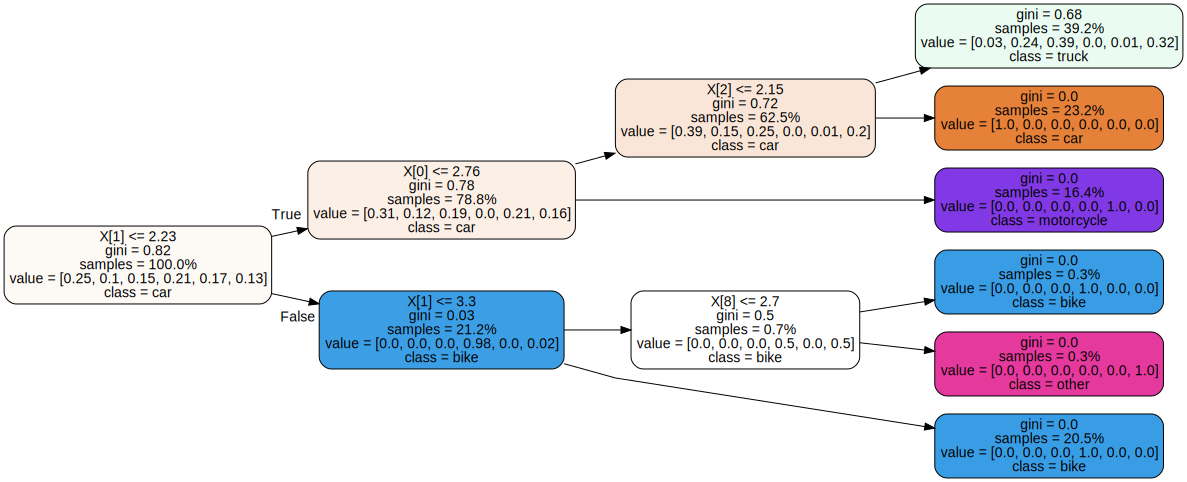

In [8]:
# extract model parameters from summary table
best_model_model_ID = summary_df_max_depth_3_sorted.model_ID.iloc[0]
best_model_module_name = summary_df_max_depth_3_sorted.module.iloc[0]

# load saved trees caulated for each model,
os.chdir(os.path.join(basedir, f"data/results/{dataset_name}_{task_name}"))
with open(f"{task_name}__{best_model_module_name}__{dataset_name}__dot_data_dict.p", 'rb') as file:  
    dot_data_dict = pickle.load(file)

# select model ID from the table above, 
graphviz.Source(dot_data_dict[best_model_model_ID]['dot_data']) #  CAUTION - this must be the last function in a cell !!!! 

# TASK 3. Do you get better results if you reduce the number of dimensions with PCA first?
---

to answer that question I created plots that allow comparing accuracy of models created usnign different parameters, and subsequently, I compared best performing models that were constructed without PCA or with different number of principial axes (10, 30 and 250)

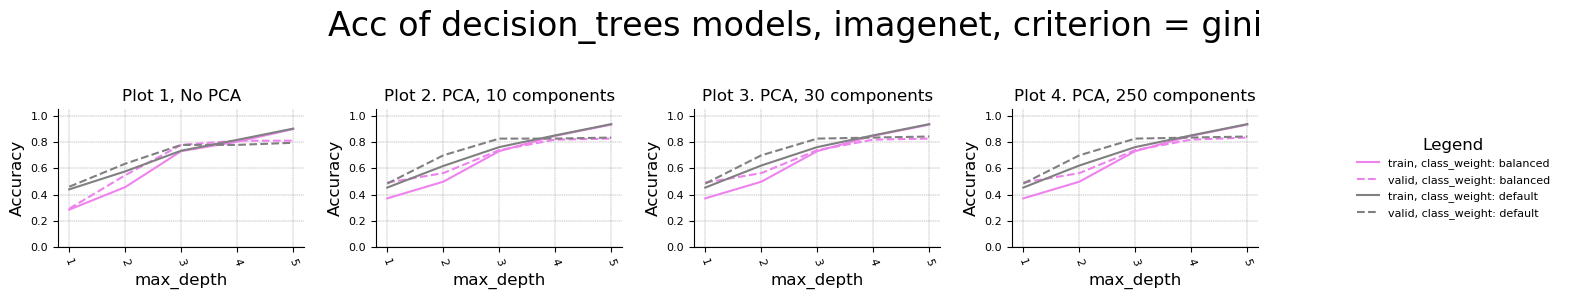

Plot_nr  model_ID         method    module  model_acc_train  \
2  Plot 3        38  decision tree  imagenet         0.935154   
3  Plot 4        39  decision tree  imagenet         0.935154   
1  Plot 2        37  decision tree  imagenet         0.935154   
0  Plot 1        12  decision tree  imagenet         0.802048   

   model_acc_valid  model_acc_test criterion  pca_components_used  max_depth  \
2         0.841270            0.90      gini                   30          5   
3         0.841270            0.90      gini                  250          5   
1         0.833333            0.90      gini                   10          5   
0         0.809524            0.74      gini                    0          4   

  class_weight  baseline_acc_train  baseline_acc_valid  baseline_acc_test  
2          NaN            0.245734            0.190476               0.22  
3          NaN            0.245734            0.190476               0.22  
1          NaN            0.245734            0.190476               0.22  
0     balanced            0.245734            0.190476               0.22

In [9]:
# plot accuracy results for models created with different parameters
for module_name in module_names:
    
    try:
        
        # reload the data
        os.chdir(PATH_results)
        summary_df = pd.read_csv(f"{task_name}__{module_name}__{dataset_name}__summary_table.csv")

        # restore deafult settign for matplolib 
        mpl.rcdefaults() 

        # summary plots and table, 
        best_performing_model_on_each_plot = model_gridsearch_summary_plots(
                data=summary_df, 
                module_names=[module_name],
                fig_title_prefix = f"Acc of {task_name} models, {module_name}, criterion =",
                create_figure = True,
                # ...
                fig_dname        = "criterion",
                subplots_dname   = "pca_components_used",
                xaxis_dname      = "max_depth",
                linecolor_dname  = "class_weight",
                linestyle_dnames = ["train", "valid"],
                # ...
                figsize=(16,3),
                fontscale=0.8,
                x_label = None,
                y_label = "Accuracy",
                y_limits = (0,1.05),
                subplots_adjust_top=0.65
            )
    
        
        # display summary table with best poerforming models, 
        display(best_performing_model_on_each_plot.sort_values("model_acc_valid", ascending=False))
  
    except:
        pass

# Plot Predictions made with the best performing model for test data
---

* The best model was selected using validation accuracy, from all compared models in that section, 
* border colors arround each picture show true class of that image (see legend, for class-color pairs),
* the groups of images (labelled on top of each group), show classyfication made by the model,
* the probability values displayed on each image were calculated using model.predict_proba() function, 
* Predictions in each group were summarized, on pie plots below the main figure, 
* you may double click on the image to make it larger, 

Found 50 images belonging to 6 classes.


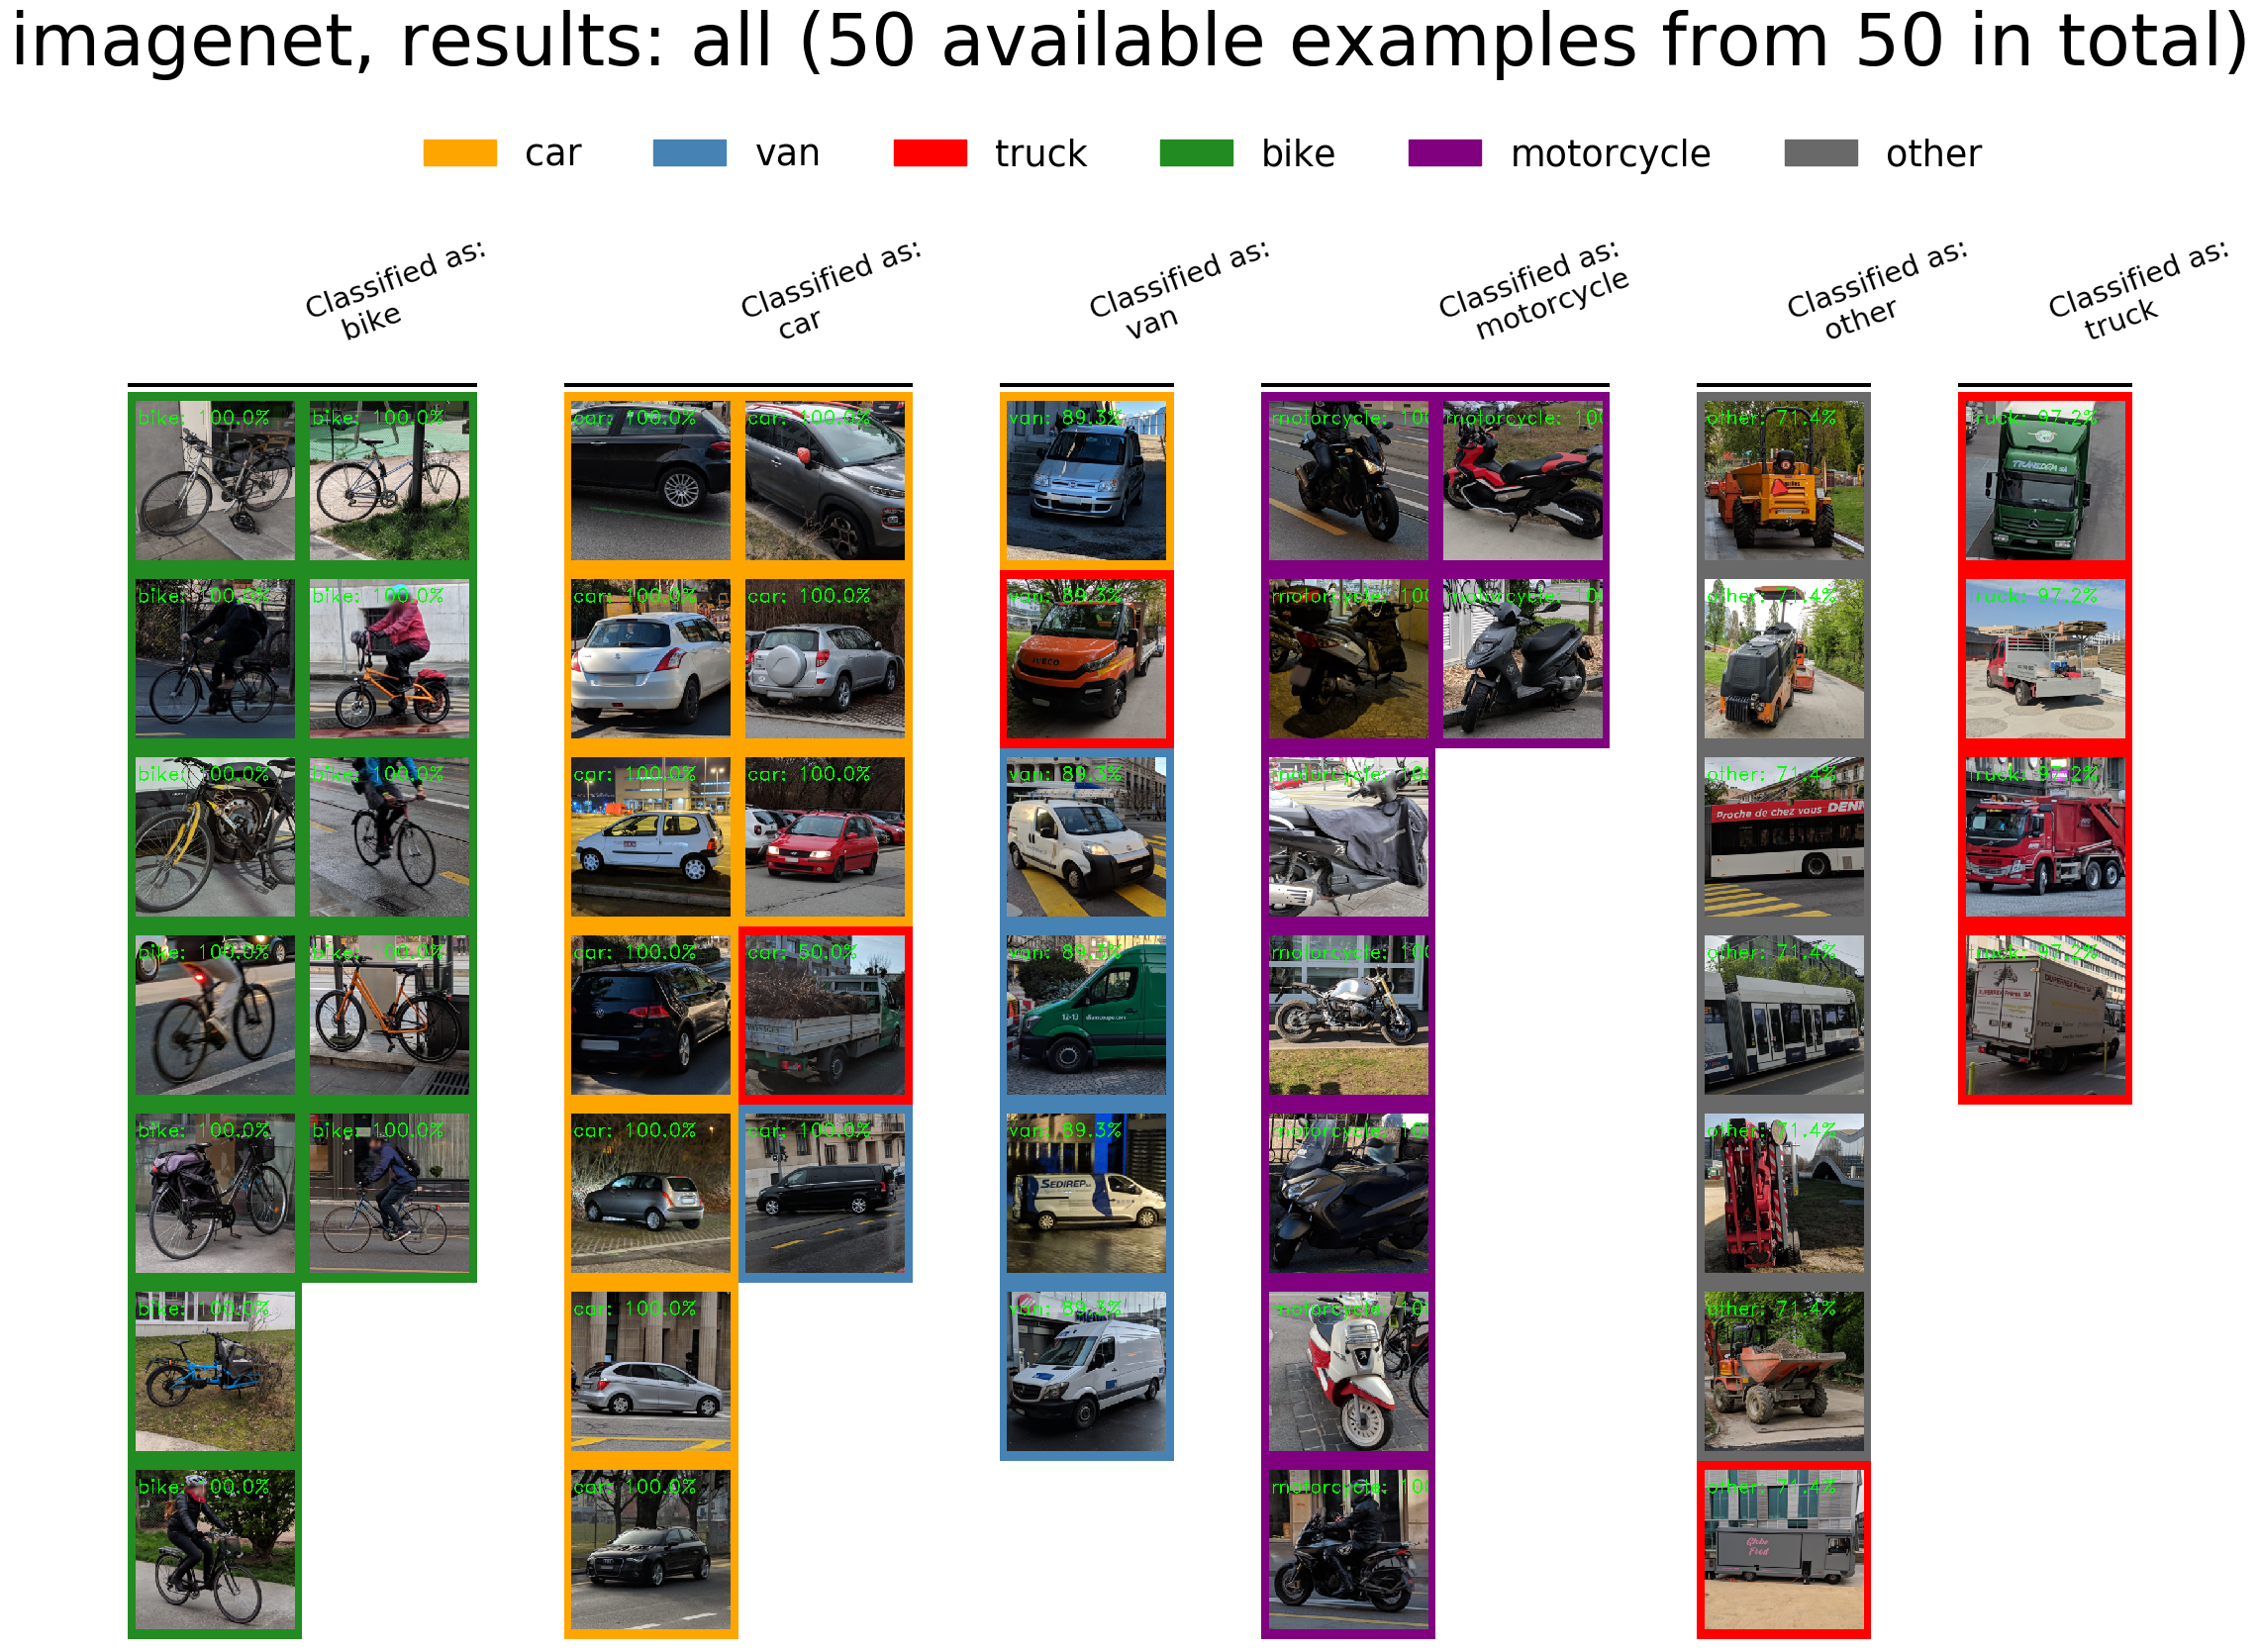

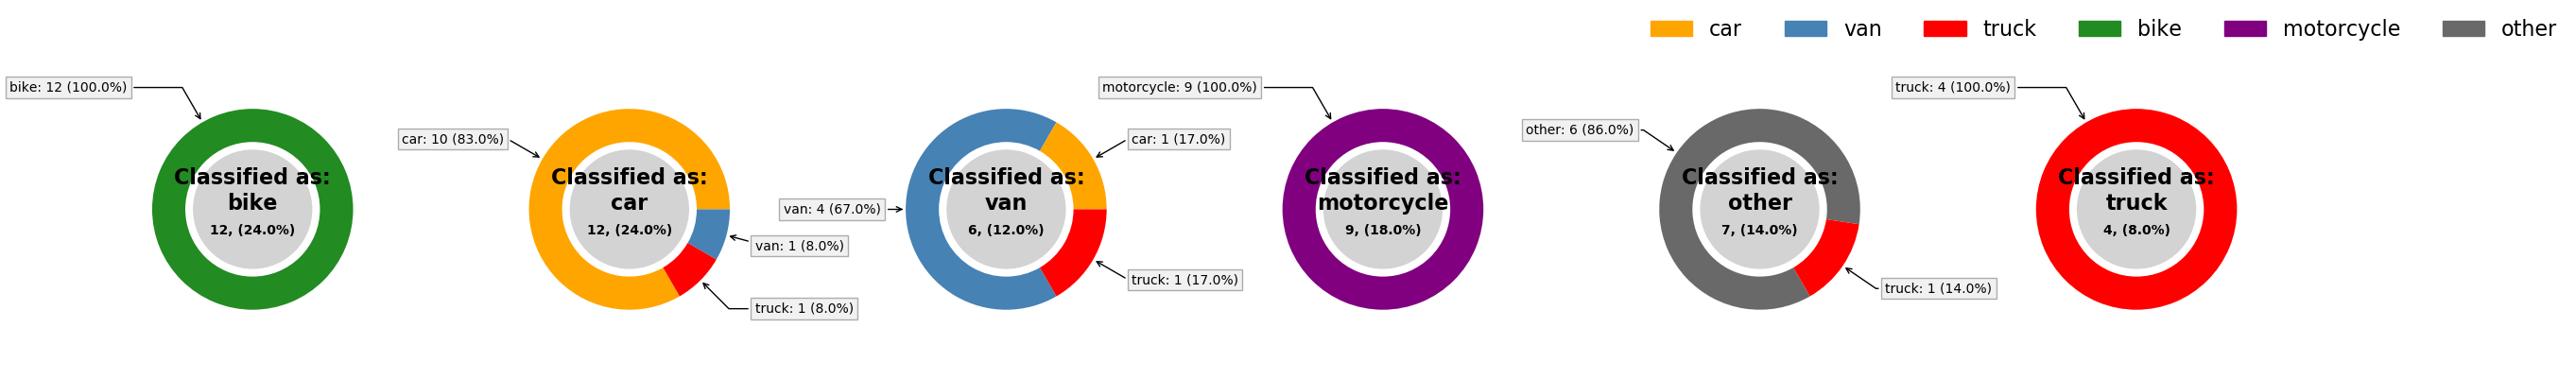

In [14]:
# select model_ID of the best performin model from the above table, 
model_ID = 38

# load model_predictions_dict
os.chdir(PATH_results)
with open(f"{task_name}__{module_names[0]}__{dataset_name}__model_predictions_dict.p", 'rb') as file: # wb - write binary,
    model_predictions_dict  = pickle.load(file) 
          
plot_examples_with_predictions_and_proba_gamma( 
    model_ID=model_ID,
    model_predictions_dict= model_predictions_dict, 
    module_name=module_names[0], 
    dataset_name=dataset_name,                              
    subset_name=["test"], # denotes test predicitons made for test_subset_names
    img_batch_subset_names=test_subset_names, 
    path_to_raw_img_batch=PATH_raw,
    class_colors=class_colors,
    make_plot_with_img_examples=True, # use False, to have only pie charts with classyfication summary                                         
    max_img_per_col=7,
    plot_classyfication_summary=True
)